## Exploring a Landsat image of Portland
The goal of this notebook is to explore rasterio and earthpy (a library built by the Earth Lab at the University of Colorado)

Some things I will do: 
Calculate the normalized difference water index (NDWI) from an image in Portland. 
Plot a RGB composite of the image. 
Mask out the clouds and calculate the NDWI again.

In [21]:
#Load spatial libraries

from glob2 import glob
import os

import numpy.ma as ma
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import patches as mpatches, colors
from matplotlib.colors import ListedColormap

import rasterio
from rasterio.mask import mask
from rasterio.plot import plotting_extent
import geopandas as gpd
from shapely.geometry import mapping

import earthpy as et
import earthpy.spatial as es

## Examine the data and practice plotting

In [10]:
# Examine my landsat image
print("Landsat on AWS")
filepath = 'http://landsat-pds.s3.amazonaws.com/c1/L8/046/028/LC08_L1TP_046028_20130617_20170309_01_T1/LC08_L1TP_046028_20130617_20170309_01_T1_B4.TIF'
with rasterio.open(filepath) as src:
    print(src.profile)

Landsat on AWS
{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 7671, 'height': 7461, 'count': 1, 'crs': CRS({'init': 'epsg:32610'}), 'transform': Affine(30.0, 0.0, 434385.0,
       0.0, -30.0, 5208915.0), 'blockxsize': 512, 'blockysize': 512, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}


Text(0,0.5,'Row #')

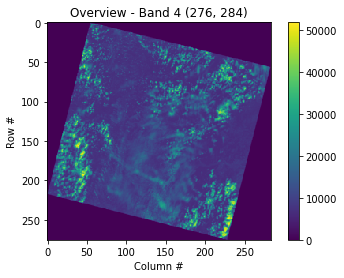

In [11]:
# Practicing opening and plotting the data
# Plot a low resultion overview
with rasterio.open(filepath) as src:
    oviews = src.overviews(1) #list the overviews from biggest to smallest
    oview = oviews[-2] #let's look at the second smallest thumbnail
    thumbnail = src.read(1, out_shape=(1, int(src.height // oview), int(src.width // oview)))

plt.imshow(thumbnail)
plt.colorbar()
plt.title('Overview - Band 4 {}'.format(thumbnail.shape))
plt.xlabel('Column #')
plt.ylabel('Row #')

Text(0,0.5,'Row #')

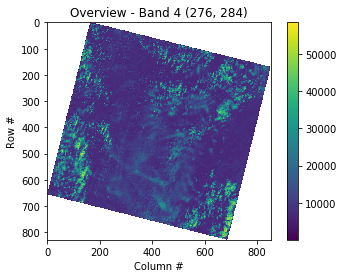

In [12]:
# Convert datatype form uint16 to float32 so we can convert the out of bounds area from 0 to NANs
with rasterio.open(filepath) as src:
    oviews = src.overviews(1) #list the overviews from biggest to smallest
    oview = oviews[1] #let's look at the second smallest thumbnail
    red = src.read(1, out_shape=(1, int(src.height // oview), int(src.width // oview)))
    
    red = red.astype('f4')
    red[red==0] = np.nan

plt.imshow(red)
plt.colorbar()
plt.title('Overview - Band 4 {}'.format(thumbnail.shape))
plt.xlabel('Column #')
plt.ylabel('Row #')

# Calculate NDWI

In [43]:
# I need to use the SWIR and NIR bands to calculate NDWI
url = 'http://landsat-pds.s3.amazonaws.com/c1/L8/046/028/LC08_L1TP_046028_20130617_20170309_01_T1/'
bband = 'LC08_L1TP_046028_20130617_20170309_01_T1_B{}.TIF'.format(2)
gband = 'LC08_L1TP_046028_20130617_20170309_01_T1_B{}.TIF'.format(3)
rband = 'LC08_L1TP_046028_20130617_20170309_01_T1_B{}.TIF'.format(4)
nirband = 'LC08_L1TP_046028_20130617_20170309_01_T1_B{}.TIF'.format(5)
swirband = 'LC08_L1TP_046028_20130617_20170309_01_T1_B{}.TIF'.format(7)
qaband = 'LC08_L1TP_046028_20130617_20170309_01_T1_B{}.TIF'.format('QA')

In [14]:
with rasterio.open(url+nirband) as src:
    profile = src.profile
    oviews = src.overviews(1) #list of overviews from biggest to smallest
    oview = oviews[1] #use second highest resolution overview
    nir = src.read(1, out_shape=(1, int(src.height // oview), int(src.width // oview)))

with rasterio.open(url+swirband) as src:
    profile = src.profile
    oviews = src.overviews(1) #list of overviews from biggest to smallest
    oview = oviews[1] #use second highest resolution overview
    swir = src.read(1, out_shape=(1, int(src.height // oview), int(src.width // oview)))

Text(0.5,1,'NDWI 3/9/2017')

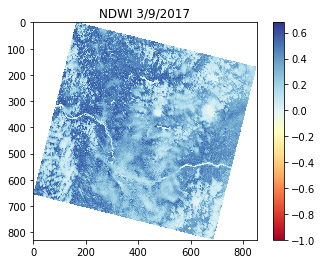

In [15]:
def calc_ndwi(nir, swir):
    """calculate NDWI from integer arrays"""
    nir = nir.astype('f4')
    swir = red.astype('f4') 
    ndwi = (nir - swir) / (nir + swir)
    return ndwi

ndwi = calc_ndwi(nir, swir)
plt.imshow(ndwi, cmap='RdYlBu')
plt.colorbar()
plt.title('NDWI 6/17/2013')

# Stack the bands

In [18]:
# Set up to stack the landsat data
file_list = [url+bband, url+gband, url+rband, url+nirband, url+swirband]
stack_output = r'C:\Users\zstat\Documents\Python\GeoExperiments\Portland\portland.tif'

In [19]:
# Stack the landsat data
es.stack_raster_tifs(file_list, stack_output, arr_out=False)

# Plot the RGB Composite Image - Two ways!

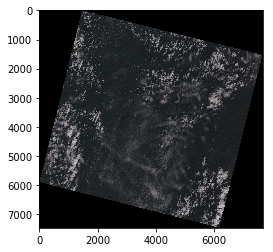

In [35]:
# Plot a true color composite 

# Open the file
raster = rasterio.open(stack_output)

# Read the grid values
red = raster.read(3)
green = raster.read(2)
blue = raster.read(1)

# Function to normalize the grid values
def normalize(array):
    """Normalizes numpy arrays into scale 0.0 - 1.0"""
    array_min, array_max = array.min(), array.max()
    return((array - array_min) / (array_max - array_min))

# Normalize the  bands
redn = normalize(red)
greenn = normalize(green)
bluen = normalize(blue)

# Test the normalized bands work
#print('min: ', redn.min(), 'max: ', redn.max(), 'mean: ', redn.mean())

# Create RGB natural color composite
rgb = np.dstack((redn, greenn, bluen))
plt.imshow(rgb)

In [53]:
# Read landsat data
with rasterio.open(stack_output) as src:
    portland = src.read(masked=True)
    landsat_extent = plotting_extent(src)

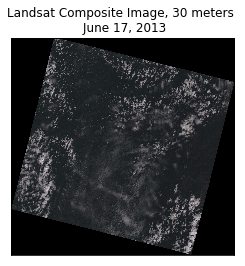

In [54]:
# Plot the RGB composite using earthypy
landsat_rgb = [2, 1, 0]

fig, ax = plt.subplots(ncols=1, nrows=1)
es.plot_rgb(portland,
           rgb=landsat_rgb,
           ax=ax,
           extent=landsat_extent)
ax.set(title="Landsat Composite Image, 30 meters \n June 17, 2013")
plt.show()

# Creating a Mask

In [55]:
# Open the QA later for your landsat scene
with rasterio.open(url+qaband) as cl:
    portland_qa = cl.read(masked=True)
    landsat_ext = plotting_extent(src)